## Commodity Price Analysis

This part of the project will focus on analysing commodity prices following the start of the genocide in Gaza.

The commodity_price_change_from_baseline mart is used for analysis, which is based on the following data: https://data.humdata.org/dataset/state-of-palestine-price-of-basic-commodities-in-gaza

The baseline price column is the commodity price before the start of the genocide, and all other listed prices are during the genocide.

### Hypothesis

It is expected during time of increased hostilities that commodity prices will be higher due to more restrictions and difficulties in obtaining aid and resources.

This could mean that commodity prices are lower during ceasefires, which occurred during the following dates:
- 24th November 2023 to 11th January 2024
- 19th January 2025 to 17th March 2025
- 3rd October 2025 to present

In [44]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
from adjustText import adjust_text
from IPython.display import display, display_html

con = duckdb.connect("../dev.duckdb")

### Average commodity prices by month

First, lets see which five months had the highest average commodity prices and which five months had the lowest average commodity prices.

In [46]:
top5 = con.execute("""
    SELECT
        STRFTIME(price_date, '%b-%Y') AS date,
        ROUND(AVG(price), 2) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY avg_price DESC
    LIMIT 5
""").df()

bottom5 = con.execute("""
    SELECT
        STRFTIME(price_date, '%b-%Y') AS date,
        ROUND(AVG(price), 2) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY avg_price ASC
    LIMIT 5
""").df()

html = f"""
<div style="display: flex; gap: 40px;">
  <div>
    <h4>Highest average prices</h4>
    {top5.to_html(index=False)}
  </div>
  <div>
    <h4>Lowest average prices</h4>
    {bottom5.to_html(index=False)}
  </div>
</div>
"""
display_html(html, raw=True)


date,avg_price
Jul-2025,424.56
May-2025,360.79
Jun-2025,360.30
Aug-2025,247.80
Dec-2024,210.03
date,avg_price
Oct-2023,15.54
Nov-2023,36.75
Feb-2025,48.76
Dec-2023,59.14


The highest average prices seem to be mostly concentrated in the May 2025 to August 2025 period, which suggests that commodities were particularly sparce during these consecutive months. The other date in the top 5 is December 2024, which could be due to it being 11 months after the previous ceasefire.

The lowest average prices generally happened at the right at the beginning of the genocide, in October 2023 to January 2024. There also was a ceasefire between the end of November until early January. The other date in the top 5, February 2025 was also during a ceasefire.

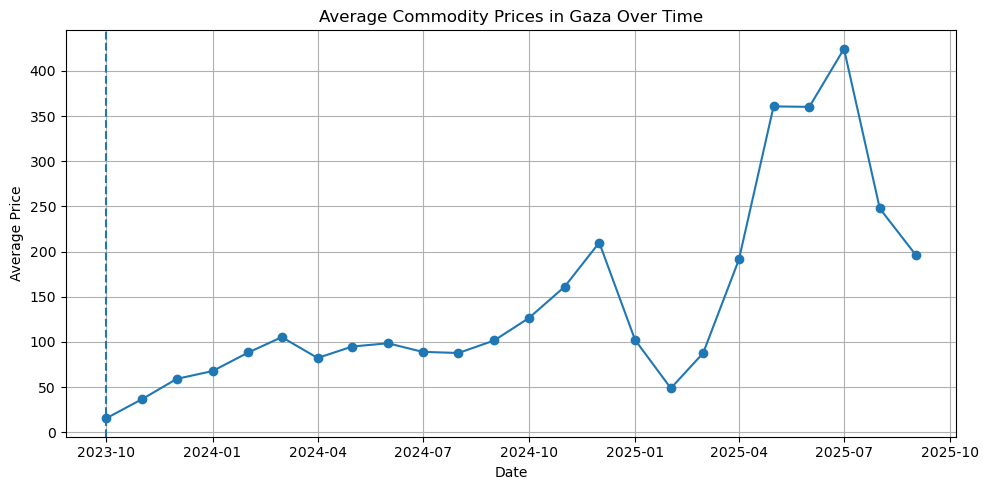

In [48]:
df = con.execute("""
    SELECT
        price_date,
        AVG(price) AS avg_price
    FROM main_mart.fct_commodity_prices_gaza
    GROUP BY price_date
    ORDER BY price_date
""").df()

plt.figure(figsize=(10, 5))
plt.plot(df["price_date"], df["avg_price"], marker='o')
plt.axvline(pd.to_datetime("2023-10-01"), linestyle="--")
plt.title("Average Commodity Prices in Gaza Over Time")
plt.xlabel("Date")
plt.ylabel("Average Price")
plt.grid(True)
plt.tight_layout()
plt.show()

By viewing the visual representation of average commodity prices over time, it can be seen that prices generally climbed when there were no active ceasefires. The two major drops in January 2025 and October 2025 can be attributed to the ceasefires in place at those times.

There was a slight reduction in prices around April 2024, meanwhile prices seemed to spike strongly either side of the January 2025 to March 2025 ceasefire. Analysing aid distribution should help in understanding why these happened, and will be investigated in the next notebook.

### Individual commodity prices by month

In this section, individual commodities will be investigated and compared. 

In the following table, the top 10 commodites with the highest percentage change from the baseline price are listed along with the date that this happened.

In [62]:
con.execute("""
    WITH max_unique AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        ROUND(price, 2) AS price,
        baseline_price,
        STRFTIME(price_date, '%b-%Y') AS date,
        pct_change_from_baseline
    FROM max_unique
    WHERE rn = 1
    ORDER BY pct_change_from_baseline DESC
""").df().head(15)

,commodity_name,unit_amount,price,baseline_price,date,pct_change_from_baseline
0,gas cylinder,12 kg,4200.00,71.25,Sep-2025,419900.0
1,pure white sugar,10 kg,3072.86,35.60,Jul-2025,307185.7
2,flour,50 kg,2592.11,91.00,May-2025,259111.1
3,marlboro cigarettes,20 pack,1933.33,24.72,Dec-2024,193233.3
4,ground coffee,1 kg,1422.86,42.08,Jul-2025,142185.7
5,l-m cigarettes,20 pack,1350.00,21.69,Dec-2024,134900.0
6,fresh lamb with bone,1 kg,510.00,56.11,Aug-2025,50900.0
7,eggs,2 kg,495.00,13.33,Sep-2025,49400.0
8,fresh veal,1 kg,460.84,45.55,Aug-2025,45984.3
9,gasoline,1 L,380.00,6.79,Aug-2025,37900.0


One thing that can be seen from this table is that almost all the items on the list saw their highest ever prices between May 2025 and September 2025. The notable exceptions are the two types of cigarettes which both saw their highest ever price in December 2024.

Since the vast majority of the items saw their highest prices roughly around the same time, plotting a graph of each commodity's maximum percentage increase from the baseline price should help visualise how much the price of each commodity increased by as a percentage.  

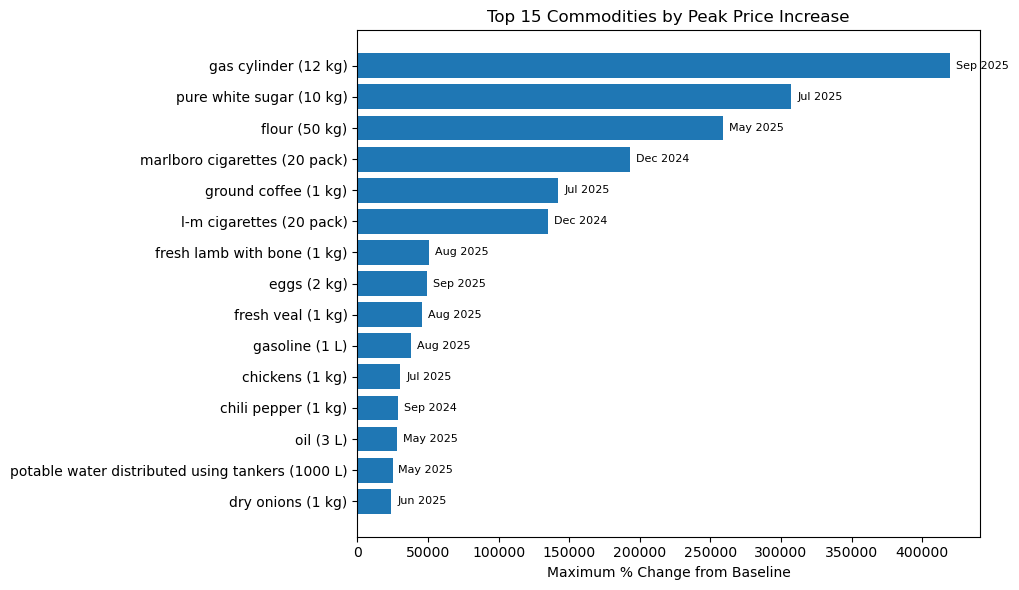

In [52]:
df = con.execute("""
    WITH ranked AS
    (
    SELECT
        commodity_name,
        unit_amount,
        baseline_price,
        price,
        pct_change_from_baseline,
        price_date,
        ROW_NUMBER() OVER (PARTITION BY commodity_name, unit_amount ORDER BY pct_change_from_baseline DESC) AS rn
    FROM main_mart.commodity_price_change_from_baseline
    )

    SELECT
        commodity_name,
        unit_amount,
        baseline_price,
        price AS max_price,
        pct_change_from_baseline AS commodity_max_pct_change,
        price_date AS max_price_date
    FROM ranked
    WHERE rn = 1
    ORDER BY pct_change_from_baseline DESC
    LIMIT 15
""").df()

plt.figure(figsize=(10, 6))
plt.barh(df["commodity_name"] + " (" + df["unit_amount"] + ")", df["commodity_max_pct_change"])
plt.gca().invert_yaxis()
plt.title("Top 15 Commodities by Peak Price Increase")
plt.xlabel("Maximum % Change from Baseline")
plt.tight_layout()

offset = df["commodity_max_pct_change"].max() * 0.01
for i, value in enumerate(df["max_price_date"]):
    plt.text(df["commodity_max_pct_change"].iloc[i] + offset, i, value.strftime("%b %Y"), va="center", fontsize=8)

plt.show()

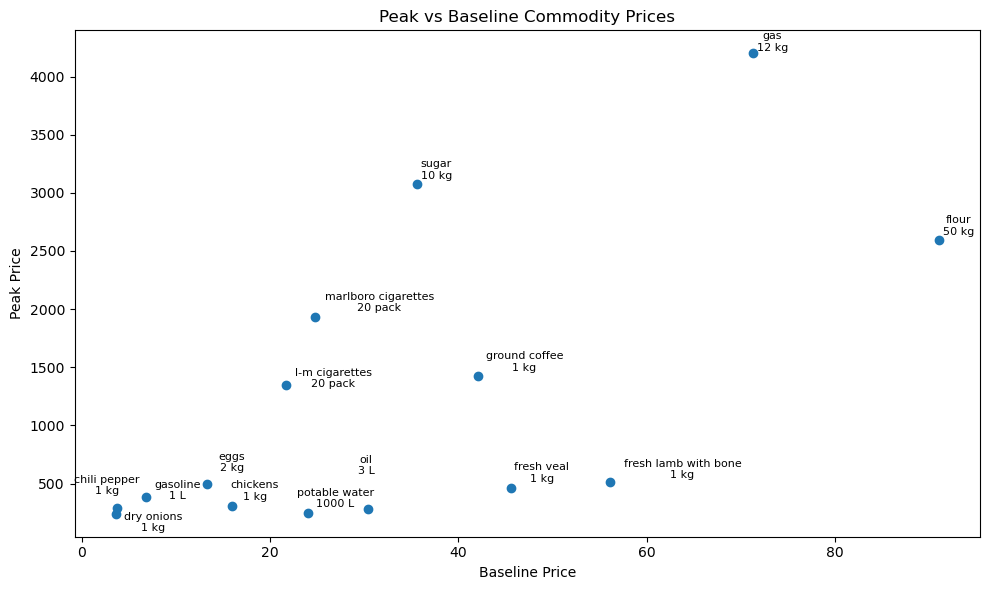

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(df["baseline_price"], df["max_price"])

df['scatter_labels'] = (
    df['commodity_name']
    .str.replace("pure white ", "")
    .str.replace(" cylinder", "")
    .str.replace(" distributed using tankers", "")
    + "\n" + df['unit_amount']
    .str.replace("liters", "L")
)

texts = []
for i in range(len(df)):
    texts.append(
    plt.text(
        df["baseline_price"].iloc[i],
        df["max_price"].iloc[i],
        df['scatter_labels'].iloc[i],
        fontsize=8
    ))

adjust_text(
    texts,
    force_text=(0.1, 0.1),
    force_points=(0.1, 0.1),
    expand_text=(1.05, 1.1),
    expand_points=(1.05, 1.1)
)

plt.xlabel("Baseline Price")
plt.ylabel("Peak Price")
plt.title("Peak vs Baseline Commodity Prices")
plt.tight_layout()
plt.show()